# [Differentiable Finite State Machines](https://google-research.github.io/self-organising-systems/2022/diff-fsm/) (supplementary code)

*Copyright 2022 Google LLC*

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

[https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [13]:
!pip install -q optax

In [14]:
#@title imports
from collections import namedtuple, Counter, defaultdict
import itertools as it
from functools import partial
from termcolor import colored
from graphviz import Digraph
import altair as alt
import pandas as pd
import matplotlib.pylab as pl
import string
import io

import numpy as np
import jax
import jax.numpy as jp
from jax import nn
from tqdm.notebook import trange
from google.colab import widgets
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
from IPython.display import HTML

import optax

In [15]:
#@title tasks {vertical-output: true}
tasks = '''
# skip every second '1'
01010100100111111
01000100000101010 

# skip every third '1'
0101010000111111
0101000000110110 

# emit every third '1'
01010100111111
00000100001001 

# emit 0s, when meet 1, start emitting 1s
00010000 
00011111

# invert bits
01001110
10110001

# generate repeating '01' sequence
00000000
01010101

# replace '1'->'111'
00100001000
00111001110

# shift right by 1 bit
0110010011001
0011001001100

# shift right by 2 bits
000111010001100100
000001110100011001

# skip every fourth '1'
01010100100111111
01010100000111011 

'''.splitlines()
task_names = [s[1:].strip() for s in tasks if s and s[0]=='#']
tasks = [t.strip() for t in tasks if t and t[0]!='#']
tasks = list(zip(tasks[::2], tasks[1::2])) 
list(enumerate(tasks))

[(0, ('01010100100111111', '01000100000101010')),
 (1, ('0101010000111111', '0101000000110110')),
 (2, ('01010100111111', '00000100001001')),
 (3, ('00010000', '00011111')),
 (4, ('01001110', '10110001')),
 (5, ('00000000', '01010101')),
 (6, ('00100001000', '00111001110')),
 (7, ('0110010011001', '0011001001100')),
 (8, ('000111010001100100', '000001110100011001')),
 (9, ('01010100100111111', '01010100000111011'))]

\begin{aligned}
T&:[\mathsf{input}, \mathsf{state}, \mathsf{state'}] \\
R&:[\mathsf{input}, \mathsf{state}, \mathsf{output}] \\
s^0&:[\mathsf{state}]
\end{aligned}


$$ y^t_{\mathsf{output}} = \sum_{\mathsf{input},\mathsf{state}} x^t_\mathsf{input} s^t_\mathsf{state} R_{\mathsf{input}, \mathsf{state}, \mathsf{output}}$$

$$ s^{t+1}_{\mathsf{state'}} = \sum_{\mathsf{input},\mathsf{state}} x^t_\mathsf{input} s^t_\mathsf{state} T_{\mathsf{input}, \mathsf{state}, \mathsf{state'}}$$

In [16]:
FSM = namedtuple('FSM', 'T R s0')

def run_fsm(fsm: FSM, inputs):
  def f(s, x):
    y  = jp.einsum('x,s,xsy->y', x, s, fsm.R)
    s1 = jp.einsum('x,s,xst->t', x, s, fsm.T)
    return s1, (y, s1)
  _, (outputs, states) = jax.lax.scan(f, fsm.s0, inputs)
  return outputs, jp.vstack([fsm.s0, states])

CHAR_N = 2
STATE_N = 8

Params = namedtuple('Params', 'T R s0')

def init_fsm(key, lazy_bias=1.0, noise=1e-3) -> Params:
  k1, k2, k3 = jax.random.split(key, 3)
  T = jax.random.normal(k1, [CHAR_N, STATE_N, STATE_N]) * noise
  T += jp.eye(STATE_N) * lazy_bias
  R = jax.random.normal(k2, [CHAR_N, STATE_N, CHAR_N]) * noise
  s0 = jax.random.normal(k3, [STATE_N]) * noise
  return Params(T, R, s0)

def hardmax(x):
  return nn.one_hot(x.argmax(-1), x.shape[-1])

def decode_fsm(params: Params, hard=False) -> FSM:
  T, R, s0 = params
  f = hardmax if hard else nn.softmax
  return FSM(f(T), f(R), f(s0))
    
def prepare_str(s):
  return nn.one_hot(list(map(int, s)), CHAR_N)  

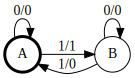

In [17]:
#@title FSM viz helpers
def show_fsm_table(fsm):
  T, R, s0 = fsm
  T, R = np.array(T), np.array(R)
  in_n, state_n, out_n = R.shape
  states = list(string.ascii_uppercase[:state_n])
  in_chars = list(string.digits[:in_n])
  out_chars = list(string.digits[:out_n])
  in_index = pd.MultiIndex.from_product([in_chars, states], names=['input', 'state'])
  state_index = pd.MultiIndex.from_arrays([['T: state\'']*state_n, states])
  out_index = pd.MultiIndex.from_arrays([['R: output']*out_n, out_chars])
  s0_index = pd.MultiIndex.from_arrays([['s0'], ['']])
  d = pd.concat([
      pd.DataFrame(T.reshape(-1, state_n), index=in_index, columns=state_index), 
      pd.DataFrame(R.reshape(-1, out_n), index=in_index, columns=out_index),
      pd.DataFrame(np.tile(s0, 2), index=in_index, columns=s0_index),      
  ], axis=1)
  s = d.style.format("{:.2f}").background_gradient(axis=None, vmin=0.0, vmax=1.0)
  s.set_table_styles([
      {'selector': '.level0.col1,.col%d,.col%d'%(state_n, state_n+out_n), 'props': 'border-left: 2px solid lightgray'},
      {'selector': '.row%d'%state_n, 'props': 'border-top: 2px solid lightgray'}
  ], overwrite=False, axis=1)
  return s

def run_fsm_str(fsm, x, normalize_states=False):
  y, s = run_fsm(fsm, prepare_str(x))
  y, s = y.argmax(-1), s.argmax(-1)
  if normalize_states:
    mapper = defaultdict(partial(next, it.count()))
    s = [mapper[i] for i in np.array(s)]
  names = string.ascii_uppercase
  s = ''.join(names[i] for i in s)
  y = ''.join(str(i) for i in y)
  return y, s
  
def show_fsm_story(xx, yy, ss):
  G = Digraph(graph_attr={'rankdir':'LR'}, node_attr={'shape':'circle'})
  G.node(ss[0], penwidth='3px')
  edges = set(zip(xx, yy, ss[:-1], ss[1:]))
  for x, y, a, b in edges:
    G.edge(a, b, '%s/%s'%(x, y))
  if len(set(ss)) > 2:
    G.engine = 'circo'
  return G

def show_fsm(fsm, xx):
  yy, ss = run_fsm_str(fsm, xx)
  return show_fsm_story(xx, yy, ss)

def show_story(fsm, x):
  x = prepare_str(x)
  y, s = run_fsm(fsm, x)
  tn, sn = s.shape
  state_names = list(string.ascii_uppercase[:sn])
  s_times, states = np.mgrid[:tn, 6:6+sn]
  xs, x_times = np.meshgrid([0, 1], np.arange(1, tn))
  ys, y_times = np.meshgrid([3, 4], np.arange(1, tn))
  row = [xs, ys, states]
  col = [x_times, y_times, s_times]
  val = [x, y, s]

  def cat(arrs):
    return np.concatenate([a.ravel() for a in arrs])
    
  pl.scatter(cat(col), cat(row), cat(val)*140.0)
  pl.axhline(2, color='black', linewidth=0.5)
  pl.axhline(5, color='black', linewidth=0.5)
  ax = pl.gca()
  ax.invert_yaxis()
  ax.set_yticks([0, 1, 3, 4]+list(range(6,6+8)));
  ax.set_yticklabels(['x=0', 'x=1', 'y=0', 'y=1']+state_names);
  ax.set_xticks(np.arange(tn))
  pl.xlabel('FSM step')
  pl.tight_layout()

T = np.float32([[[1,0],[0,1]], [[0,1],[1,0]]])
R = np.float32([[[1,0],[1,0]], [[0,1],[1,0]]])
s0 = np.float32([1,0])
fsm = FSM(T, R, s0) 

g = show_fsm(fsm, tasks[6][0])
g.render('task0_ref_fsm', format='svg')
display(g)
tab = show_fsm_table(fsm)
tab.to_html('task0_ref.html')

$$p_i = {1 \over N_\mathsf{step}}\sum_t s^t_i$$

$$H = -\sum_i p_i log(p_i) $$

$$L_\mathsf{total} = L_\mathsf{error} + w_H H$$

## Loss function and Trainer class

In [18]:
Stats = namedtuple('Stats', 'total error entropy states_used')

def entropy(p):
  return jp.where(p>0.0, -p*jp.log(p), 0.0).sum()

def loss_f(params, x, y0, entropy_weight, hard=False):
  fsm = decode_fsm(params, hard=hard)
  y, s = run_fsm(fsm, x)
  error = jp.square(y-y0).sum()
  entropy_loss = entropy(s.mean(0)) * entropy_weight
  total = error + entropy_loss
  states_used = s.max(0).sum()
  return total, Stats(
      total=total, error=error, entropy=entropy_loss, states_used=states_used)

TrainState = namedtuple('TrainState', 'params opt_state')
TrainResult = namedtuple('TrainResult', 'params eval logs')

train_step_n = 400
optimizer = optax.adam(0.25, 0.5, 0.5)

class Trainer:
  def __init__(self, x, y0, entropy_weight=0.01, lazy_bias=1.0):
    x, y0 = prepare_str(x), prepare_str(y0)
    self.task = (x, y0)
    self.loss_f = partial(loss_f, x=x, y0=y0, entropy_weight=entropy_weight)
    self.lazy_bias = lazy_bias

  @partial(jax.jit, static_argnums=(0,))
  def train_step(self, train_state):
    params, opt_state = train_state
    grad_f = jax.grad(self.loss_f, has_aux=True)
    grads, stats = grad_f(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return TrainState(params, opt_state), stats

  def run(self, key):
    logs = []
    params0 = init_fsm(key, lazy_bias=self.lazy_bias)
    opt_state = optimizer.init(params0)
    train_state = TrainState(params0, opt_state)
    for i in range(train_step_n):
      train_state, stats = self.train_step(train_state)
      logs.append(stats)
    _, eval = self.loss_f(train_state.params, hard=True)
    return TrainResult(train_state.params, eval, logs)

entropy_weight = 0.000000


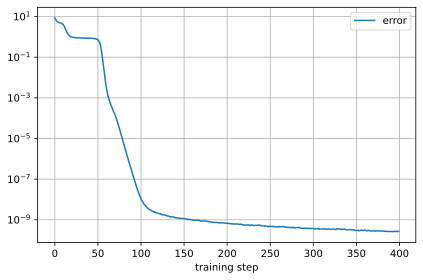

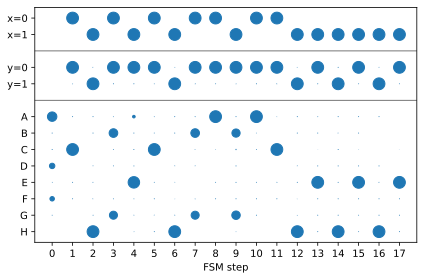

entropy_weight = 0.010000


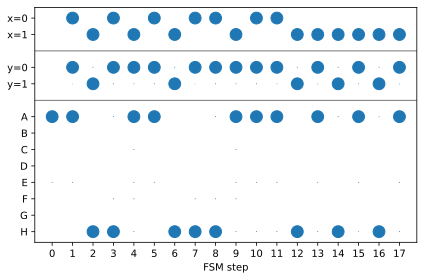

In [19]:
x, y0 = tasks[0]
key = jax.random.PRNGKey(1)

def run_with_entropy_weight(entropy_weight):
  print('entropy_weight = %f'%entropy_weight)  
  return Trainer(x, y0, entropy_weight=entropy_weight, lazy_bias=0.0).run(key)

r = run_with_entropy_weight(0.0)
soft_fsm = decode_fsm(r.params)

pl.figure()
pl.yscale('log')
pl.plot([s.error for s in r.logs], label='error')
pl.grid()
pl.legend()
pl.xlabel('training step')
pl.tight_layout()
pl.savefig('loss_goes_down.svg')
pl.show()

show_story(soft_fsm, x)

pl.savefig('task_0_story_naive.svg')
pl.show()

r = run_with_entropy_weight(0.01)
show_story(decode_fsm(r.params), x)
pl.xlabel('FSM step')
pl.savefig('task_0_story_w_entropy.svg')
pl.show()

# Regularization and initalization study

In [20]:
def plot_results(r):
  s = jp.where(r.eval.error==0, r.eval.states_used, 0)
  df = pd.DataFrame(np.int32(s), index=ws).melt(ignore_index=False, value_name='states used')
  df.index.name = 'entropy weight'
  df = df.reset_index()
  df[df==0] = 'error'
  df['states used'] = df['states used'].astype('str')
  df['entropy weight'] = df['entropy weight'].map('{:.3g}'.format)

  base = alt.Chart(df, width=150, height=200).encode(
      x=alt.X('states used'),
      y=alt.Y('count()', axis=alt.Axis(title='run count')),
      color=alt.condition(
          alt.datum['states used'] == 'error', 
          alt.value('red'),
          alt.value('steelblue')
      ))
  chart = alt.layer(
    base.mark_bar(),
    base.mark_text(dy=-5).encode(text='count()')
  ).facet(
    column='entropy weight'
  )
  display(chart)

x, y0 = tasks[0]
keys = jax.random.split(key, 100)
ws = jp.array([1.0, 0.1, 0.01, 0.001])

def run_lazy_bias(lazy_bias):
  def run_w(w):
    trainer = Trainer(x, y0, entropy_weight=w, lazy_bias=lazy_bias)
    return jax.vmap(trainer.run)(keys)
  print('lazy_bias=%.1f'%lazy_bias)
  r = jax.vmap(run_w)(ws)
  plot_results(r)

run_lazy_bias(0.0)
run_lazy_bias(1.0)

lazy_bias=0.0


alt.FacetChart(...)

lazy_bias=1.0


alt.FacetChart(...)

# 10 toy tasks

In [21]:
#@title task evaluation helpers
def plot_eval(r):
  use = np.array(np.int32(r.eval.states_used), str)
  use = np.where(r.eval.error==0, use, 'err')
  c = Counter(use)
  c = dict(sorted(c.items()))
  labels, vals = list(c.keys()), list(c.values())
  pl.figure(figsize=(4, 0.25+0.25*len(c)))
  pl.barh(labels, vals)
  if 'err' in c:
    pl.barh('err', c['err'], color='red')
  for i, n in enumerate(vals):
    pl.text(vals[i]+1, i-0.2, str(vals[i]))
  pl.grid(axis='x')

def plot_good_fsms(r, x, y):
  def f(params):
    fsm = decode_fsm(params, hard=True)
    return run_fsm(fsm, prepare_str(x))
  _, ss = jax.vmap(f)(r.params)
  good = r.eval.error == 0
  min_used_states = r.eval.states_used[good].min()
  good &= r.eval.states_used == min_used_states
  names = string.ascii_uppercase
  cnt = Counter()
  for s in ss[good].argmax(-1):
    mapper = defaultdict(partial(next, iter(names)))
    s = ''.join(mapper[i] for i in np.array(s))
    cnt.update([s])
  code = []
  for s, n in cnt.most_common():
    g = show_fsm_story(x, y, s)
    svg = g.pipe('svg').decode(g._encoding)
    code.append('<div class="fsm">%s x %d</div>'%(svg, n))
  if len(code) > 1:
    code = f'''{code[0]}<details><summary><b>Click to see all FSMs ({len(code)-1} more)</b></summary>
    {''.join(code[1:])}</details>'''
  else:
    code = code[0]
  return code

fsm_style = '''
  <style>
    .taskinfo {
      display:inline-block;
      vertical-align: top;
      width:400px;
    }
    .taskblock {
      border-top-style: solid;
    }
    .fsm {
      font-size: 1.6em;
      display:inline-block;
      white-space: nowrap;
      margin-right: 20px;
      margin-bottom: 10px;}
    .fsm svg {
      display:inline-block; vertical-align: middle;
      width: auto; max-height: 180px;
    }
  </style>
'''

In [22]:
#@title run all
key = jax.random.PRNGKey(1)
run_n = 1000
keys = jax.random.split(key, run_n)

display(HTML(fsm_style))

results = []
all_codes = []
for i, (x, y0) in list(enumerate(tasks)):
  trainer = Trainer(x, y0)
  r = jax.vmap(trainer.run)(keys)
  results.append(r)

  plot_eval(r)
  pl.ylabel('states N')
  f = io.StringIO()
  pl.savefig(f, format='svg', bbox_inches='tight')
  pl.close()
  fsms = plot_good_fsms(r, x, y0)
  code = f'''<div class="taskblock">
  <div class="taskinfo"><pre><b>Task {i}: {task_names[i]}</b>
Training input  : {x}
Expected outout : {y0}
</pre>{f.getvalue()}</div>
{fsms}</div>'''
  display(HTML(code))
  all_codes.append(code)
all_codes.append('<div class="taskblock"></div>')
open('all_tasks.html', 'w').write('\n'.join(all_codes));


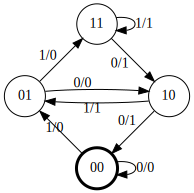

In [23]:
#@title Task 8 (2-bit shift) viz
x, y0 = tasks[8]
r = results[8]
best_i = (r.eval.states_used+r.eval.error*10000).argmin()
best_params = jax.tree_util.tree_map(lambda x:x[best_i], r.params)
best_fsm = decode_fsm(best_params, hard=True)
y, s = run_fsm_str(best_fsm, x, normalize_states=True)
g = show_fsm_story(x, y, s)
g.node('A', label='00')
g.node('B', label='01')
g.node('C', label='11')
g.node('D', label='10')
g.render('2bitshift', format='svg')
g